In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm import tqdm
from umap import UMAP

In [6]:
from torchvision import transforms

In [7]:
%matplotlib inline

In [8]:
train_labels = context.catalog.load('train_labels')

2020-12-04 12:24:26,865 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [9]:
train_labels

image_id  label
0      1000015157.jpg      0
1      1000201771.jpg      3
2       100042118.jpg      1
3      1000723321.jpg      1
4      1000812911.jpg      3
...               ...    ...
21392   999068805.jpg      3
21393   999329392.jpg      3
21394   999474432.jpg      1
21395   999616605.jpg      4
21396   999998473.jpg      4

[21397 rows x 2 columns]

In [10]:
label_num_to_disease_map = context.catalog.load('label_num_to_disease_map').to_dict()[0]

2020-12-04 12:24:27,320 - kedro.io.data_catalog - INFO - Loading data from `label_num_to_disease_map` (JSONDataSet)...


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
label_num_to_disease_map

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{0: 'Cassava Bacterial Blight (CBB)',
 1: 'Cassava Brown Streak Disease (CBSD)',
 2: 'Cassava Green Mottle (CGM)',
 3: 'Cassava Mosaic Disease (CMD)',
 4: 'Healthy'}

In [12]:
train_images_torch = context.catalog.load('train_images_torch')

2020-12-04 12:24:27,890 - kedro.io.data_catalog - INFO - Loading data from `train_images_torch` (ImageFolderDataSet)...


In [13]:
assert len(train_images_torch) == len(train_labels)

In [14]:
assert train_images_torch[101][1] == train_labels.iloc[101].label

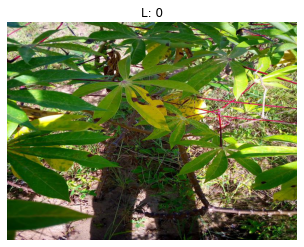

In [16]:
image, label = train_images_torch[0]
plot_image(image, label)

# Image examples

In [17]:
targets = np.array(train_images_torch.labels)

In [18]:
def plot_label_examples(targets, target_label):
    label_indices = np.where(targets == target_label)[0]
    
    sample = np.random.choice(label_indices, 6)

    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, idx in zip(grid, sample):
        img, label = train_images_torch[idx]
        assert label == target_label
        plot_image(img, ax=ax)
    plt.suptitle(f'Label {target_label}')
    plt.show()


## Label 0: CBB

In [19]:
print(label_num_to_disease_map[0])

Cassava Bacterial Blight (CBB)


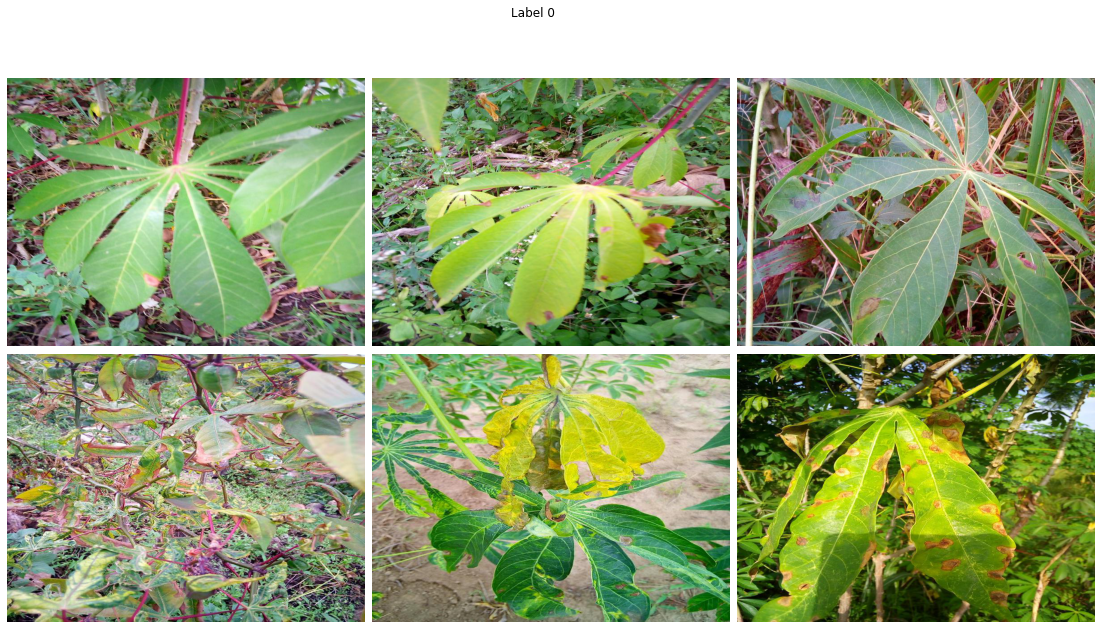

In [20]:
plot_label_examples(targets, 0)

## Label 1: CBSD

In [21]:
print(label_num_to_disease_map[1])

Cassava Brown Streak Disease (CBSD)


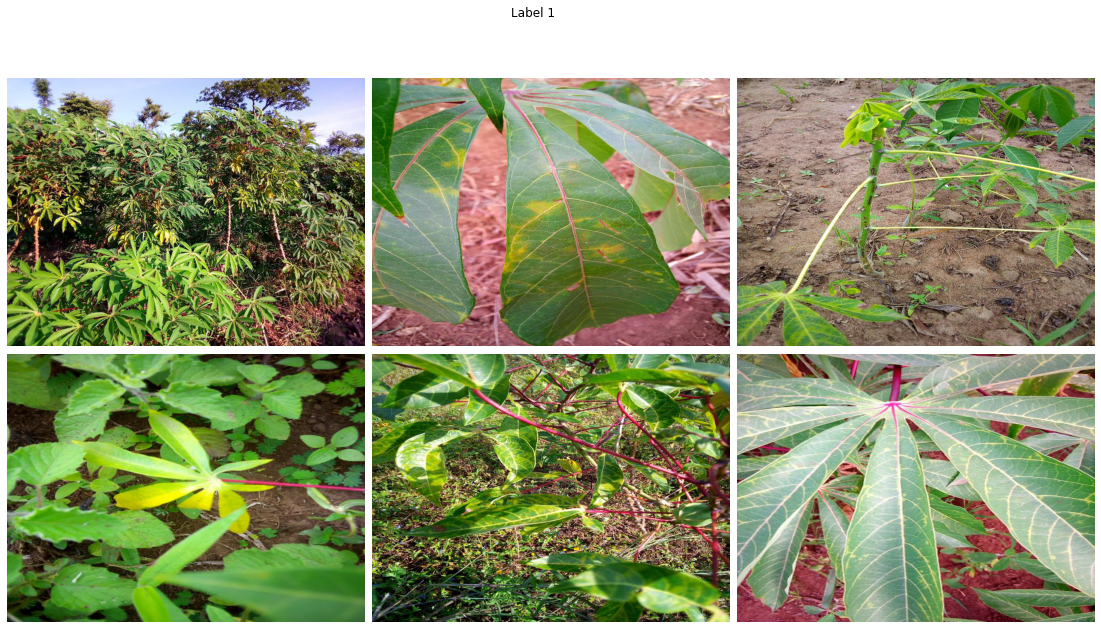

In [22]:
plot_label_examples(targets, 1)

## Label 2: CGM

In [23]:
print(label_num_to_disease_map[2])

Cassava Green Mottle (CGM)


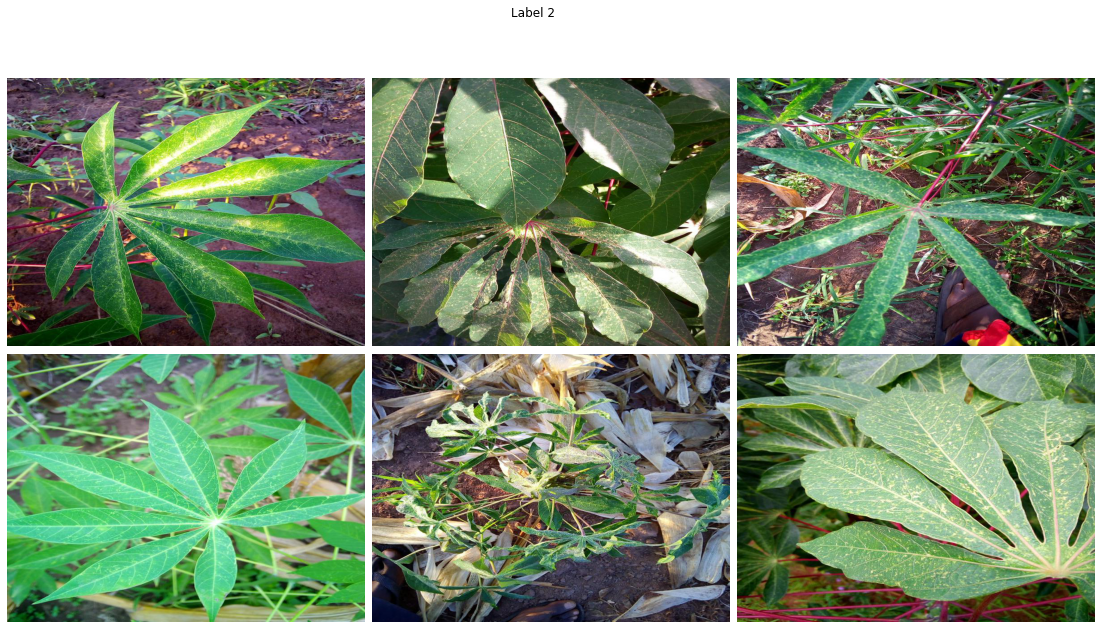

In [24]:
plot_label_examples(targets, 2)

## Label 3: CMD

In [25]:
print(label_num_to_disease_map[3])

Cassava Mosaic Disease (CMD)


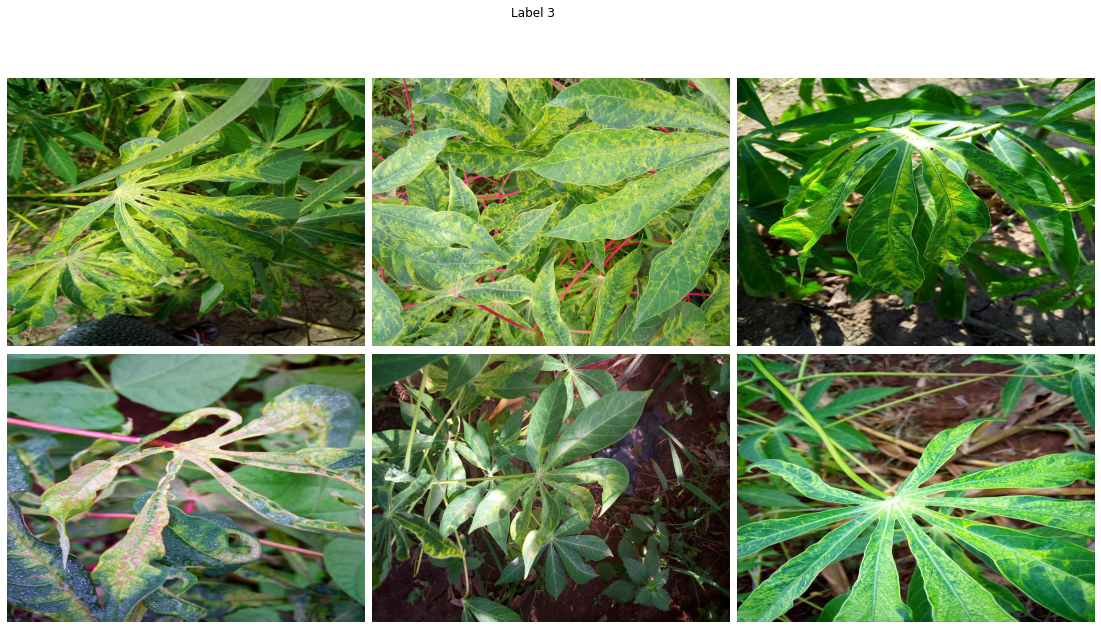

In [26]:
plot_label_examples(targets, 3)

## Label 4: Healthy

In [27]:
print(label_num_to_disease_map[4])

Healthy


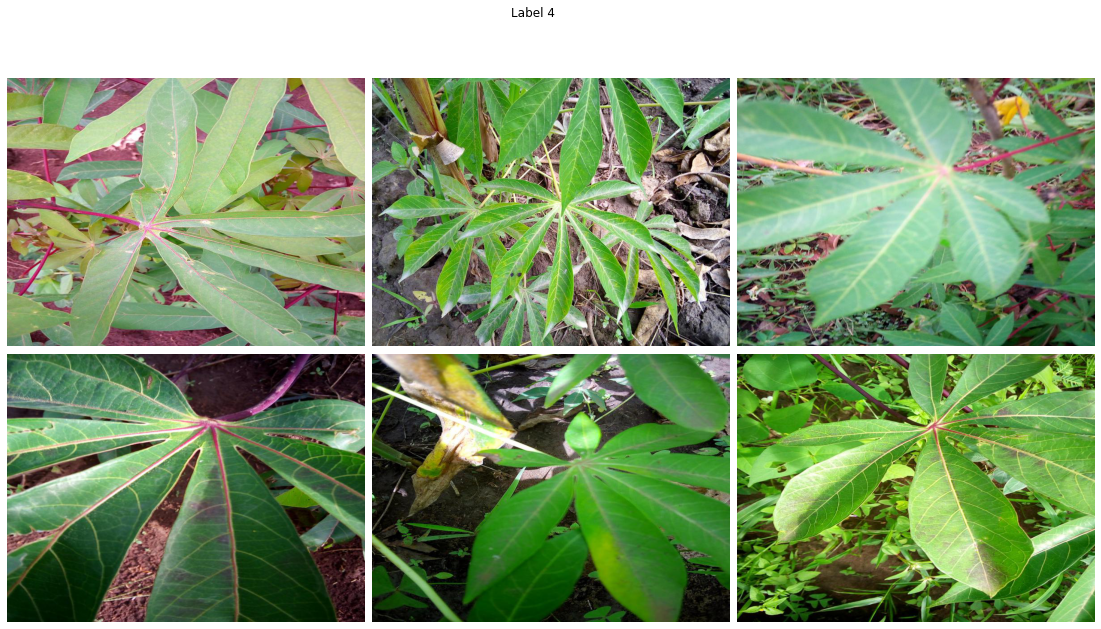

In [28]:
plot_label_examples(targets, 4)

# Class distribution

In [29]:
train_labels['label_name'] = train_labels.label.apply(lambda x: label_num_to_disease_map[x])

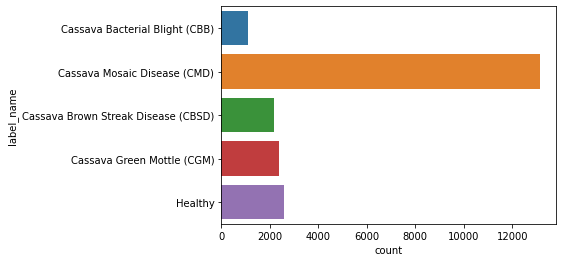

In [30]:
sns.countplot(y=train_labels['label_name'])
plt.show()

# UMAP visualization

In [31]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((60, 80)),
    transforms.ToTensor()
])

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
train_images_torch.transform = transform

In [33]:
sample_size = 500

In [34]:
import skimage
from skimage import color

In [35]:
arrays = []
labels = []
image_ids = []
for target_label in [0, 1, 2, 3, 4]:
    label_indices = np.where(targets == target_label)[0]
    
    sample_indices = np.random.choice(label_indices, sample_size)
    
    for idx in tqdm(sample_indices):
        img, label = train_images_torch[idx]
        img_id = train_images_torch.image_ids[idx]
        
        rgb_to_hsv = skimage.color.rgb2hsv(img.permute(2, 1, 0))
        histogram, edges = np.histogram(rgb_to_hsv, bins=260)
        
        assert label == target_label
        arrays.append(histogram)
        labels.append(label)
        image_ids.append(img_id)

  0%|          | 0/500 [00:00<?, ?it/s]/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/skimage/util/dtype.py:226: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  dtypeobj_out = np.dtype(dtype)
100%|██████████| 500/500 [00:06<00:00, 73.47it/s]


In [36]:
len(arrays)

2500

In [37]:
arrays = np.stack(arrays)
arrays.shape

(2500, 260)

In [38]:
assert len(arrays) == len(labels)

In [39]:
reducer = UMAP(random_state=42)

In [40]:
transformed = reducer.fit_transform(arrays)

In [41]:
tr_x, tr_y = transformed[:, 0], transformed[:, 1]

/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


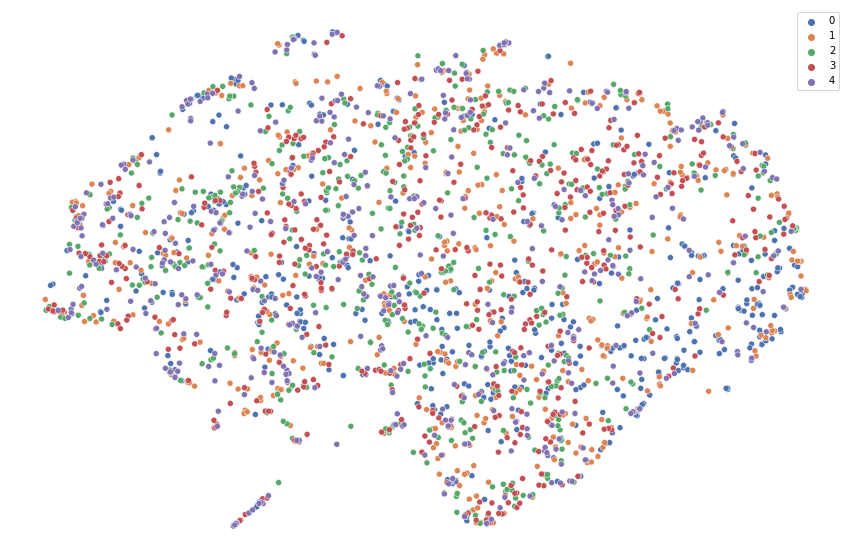

In [42]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=labels, palette="deep")
plt.axis('off')
plt.show()